#### Now, let's start processing indoor/outdoor images dataset to solve binary classification problem!

#### Starting with packages importing:

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import torch
import torch.nn as nn 
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.models import vgg16
from catboost import CatBoostClassifier

import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import PIL

from IPython.display import clear_output
from tqdm.auto import tqdm
import sys

#### First, let's load the images:

In [2]:
transform_images = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),            
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

def load_datasets(images_dir = './data', transform = transform_images, batch_size = 4, train_size = 0.7, val_size = 0.15):

    '''Loads images from folders and completes split of data on train, validation and test'''
    
    images_dataset = ImageFolder(root=images_dir, transform=transform)

    train_size = int(train_size * len(images_dataset))  # 70% for train
    val_size = int(val_size * len(images_dataset))   # 15% for validation
    test_size = len(images_dataset) - train_size - val_size  # Rest for the test

    # Split of dataset
    train_dataset, val_dataset, test_dataset = random_split(images_dataset, [train_size, val_size, test_size])

    # DataLoader creation 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_datasets()

#### Data is loaded. Let's check it:

In [3]:
def check_after_dataload(dataloader, break_iter = True):
    
    for images, labels in dataloader:
        print(images.size(), labels)
        if break_iter:
            break
        
check_after_dataload(train_loader)

torch.Size([4, 3, 128, 128]) tensor([0, 0, 1, 0])


#### Looks like it works fine, now we should plot images to check this. And here we'll use TensorBoard:

In [4]:
writer_images = SummaryWriter('runs/indoor_outdoor_images')

tensor([1, 0, 1, 0])


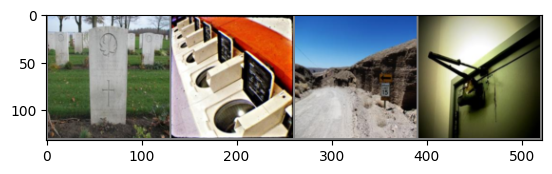

In [5]:
# Function from tensorboard documentation
def matplotlib_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)
    img = img * 0.5 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# function for TensorBoard usage
def tensorboard_images_check(dataloader, num_batches = 5):
    
    for i, batch in enumerate(dataloader):
        images, labels = batch
        img_grid = torchvision.utils.make_grid(images)
        if i > num_batches:
            break
        else:
            writer_images.add_image(f'outdoor/indoor_experiment_{i+1}', img_grid)
            writer_images.add_text(f'labels: ', str(labels), 0)


dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)
print(labels)

tensorboard_images_check(dataloader=train_loader)

#### And this works, actually:

<img src="pictures/images_tb.png" style="height: 400px; width:750px;"/>

<img src="pictures/labels_tb.png" style="height: 400px; width:750px;"/>

#### Then, let's dive into some deeper analysis:

#### ~102k batches here \<OMG\>

In [18]:
def compare_length_datasets(dataloader):

    '''Function that calcs number of labels presented in dataset'''
    
    labels_total = np.array([])

    for batch in tqdm(dataloader):

        images, labels = batch

        labels = labels.cpu().numpy()
        labels_total = np.append(labels_total, labels)
    
    return labels_total

labels_array = compare_length_datasets(train_loader)

  0%|          | 0/71842 [00:00<?, ?it/s]

#### Labels acquired. Let's get some info from it:

In [19]:
def get_classes_info(array):
    '''Prints some info about data'''  

    print(f"Number of images in dataset: {len(array)}")
    print(f"Number of classes presented in data: {len(np.unique(array))}")

    print()
    
    mask_class_1 = np.where(array ==  0)
    mask_class_2 = np.where(array == 1)

    first_class = array[mask_class_1]
    second_class = array[mask_class_2]

    print(f"Number of images by class 0: {len(first_class)}")
    print(f"Number of images by class 1: {len(second_class)}")

    print()

    if len(first_class) == len(second_class):
        print("No disbalance in data")
        print()
    
    else:
        if len(first_class) > len(second_class):
            print("Disbalance: number in first is greater")
        else:
            print("Disbalance: number in second is greater")
        print(f"Difference: {abs(len(first_class) - len(second_class))}")


get_classes_info(labels_array)

Number of images in dataset: 287366
Number of classes presented in data: 2

Number of images by class 0: 150729
Number of images by class 1: 136637

Disbalance: number in first is greater
Difference: 14092


#### There's a prevalence of first class here... That's why we should probably apply augmentation techniques for the second class later!

#### I want to try PCA on Images to get 2 dimensions as result. After that let's try plotting it:

In [ ]:
def crazy_pca_idea(dataloader):
    
    features = []
    labels_list = []

    writer = SummaryWriter('runs/feature_visualization')

    for images, labels in tqdm(dataloader):
        images = images.numpy()  
        images = images.reshape(images.shape[0], -1)  
        features.append(images)
        labels_list.append(labels.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels_list)

    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    for i in range(features_2d.shape[0]):
        writer.add_scatter('PCA', features_2d[i], label=str(labels[i]))
    
    writer.close()

crazy_pca_idea(train_loader)

#### Ok, kernel died. But completing the embeddings (or doing the data splits), I'll try doing this.

#### Then, let's make train, validation and test split (This step was made in the head of this file).

#### Ok, let's start processing this with our own CNN approach:

In [121]:
class CNNIndoorOutdoorClf(nn.Module):
    
    def __init__(self):
        super(CNNIndoorOutdoorClf, self).__init__()
        self.convolution_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_image):
        x = self.convolution_layers(input_image)
        x = x.view(x.size(0), -1)  
        x = self.fully_connected_layers(x)

        # print(f"final output is: {x}")
        # print(f"final output size is: {x.size()}")

        # print((x > 0.5).long())
        
        return x

#### Ok, next we try learning this model!

In [122]:
def set_model(model):

    if torch.backends.mps.is_available():
        device = torch.device("mps")  
        print(f"MPS available. Device used.")
    else:
        device = torch.device("cpu")  
        print("CUDA is unavailable. CPU is used.")
    
    modelCNN = model()
    modelCNN.to(device)

    return modelCNN, device

IndoorOutdoorModelCNN, device = set_model(CNNIndoorOutdoorClf)

MPS available. Device used.


#### Let's add CNN graph to the TensorBoard:

In [123]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.to(device)

writer_images.add_graph(IndoorOutdoorModelCNN, images)

#### Now we're able to look at the full architecture of our model:

<img src="pictures/model_tb.png" style="height: 400px; width:750px;"/>

#### And let's start learning:

In [77]:
writer = SummaryWriter('runs/running_indoor_outdoor_model')

In [78]:
modelCNNIndoorOutdoor = CNNIndoorOutdoorClf().to(device)  
optimizer = optim.Adam(modelCNNIndoorOutdoor.parameters(), lr=0.001) 
criterion = nn.BCELoss()

In [79]:
def test_loss(train_loader, device):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    images, labels = images.to(device), labels.to(device).float()

    outputs = modelCNNIndoorOutdoor(images).to('mps')

    loss = criterion(outputs, labels.view(labels.size(0), -1))

    return loss

print(test_loss(train_loader, device))


tensor(0.6899, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [153]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Save model state"""
    torch.save(state, filename)

def load_checkpoint(modelCNN, optimizer, filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    modelCNN.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, file, device = 'cpu', num_epochs=10, first_flag = True):
    if first_flag:
        best_val_acc = 0.0
        epoch_last = 0
    else:
        epoch_last, loss, accuracy = load_checkpoint(model, optimizer, file)
        best_val_acc = accuracy
    
    model = model.to(device)

    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()

            outputs = model(inputs)

            # print(outputs)
            # print(labels)
            
            loss = criterion(outputs, labels.view(labels.size(0), -1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs.view(-1) > 0.5).long() 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        # scheduler.step()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        writer.add_scalar('Loss/train', train_loss, epoch + epoch_last)
        writer.add_scalar('Accuracy/train', train_acc, epoch + epoch_last)
        writer.add_scalar('Loss/val', val_loss, epoch + epoch_last)
        writer.add_scalar('Accuracy/val', val_acc, epoch + epoch_last)
        

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, file)
            
    
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(labels.size(0), -1))
            running_loss += loss
            predicted = (outputs.view(-1) > 0.5).long() 
            # print(predicted)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(test_loader)  
    accuracy = correct / total 
    
    print(f'Accuracy on test set: {accuracy:.4f}')
    print(f'Average Loss on test set: {avg_loss:.4f}')

    return avg_loss, accuracy

def predict_model(model, test_loader, device, threshold_test):
    model.eval()

    predicted_array = []
    labels_array = []
    # correct = 0
    # total = 0
    # running_loss = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device).float().numpy()
            outputs = model(inputs)
            # loss = criterion(outputs, labels.view(labels.size(0), -1))
            # running_loss += loss
            predicted = (outputs.view(-1) > 0.5).long().numpy()
            # print(predicted)
            predicted_array.append(predicted)
            labels_array.append(labels)
            # print(predicted)
            # correct += (predicted == labels).sum().item()
            # total += labels.size(0)
            if i > threshold_test:
                break

    # avg_loss = running_loss / len(test_loader)  
    # accuracy = correct / total 
    
    # print(f'Accuracy on test set: {accuracy:.4f}')
    # print(f'Average Loss on test set: {avg_loss:.4f}')

    accuracy = accuracy_score(y_pred=np.concatenate(predicted_array), y_true=np.concatenate(labels_array))
    classification_report_task = classification_report(y_pred=np.concatenate(predicted_array), y_true=np.concatenate(labels_array))
    confusion_matrix_task = confusion_matrix(y_pred=np.concatenate(predicted_array), y_true=np.concatenate(labels_array))

    return classification_report_task, confusion_matrix_task, accuracy

In [174]:
modelCNNIndoorOutdoor = CNNIndoorOutdoorClf()  
optimizer = optim.Adam(modelCNNIndoorOutdoor.parameters(), lr=0.001) 
criterion = nn.BCELoss()

#### Let's reduce the No. of samples and continue learning this:

In [175]:
train_loader, val_loader, test_loader = load_datasets()

In [176]:
len(train_loader), len(val_loader), len(test_loader)

(71842, 15395, 15395)

In [ ]:
train_model(modelCNNIndoorOutdoor, train_loader, val_loader, criterion, optimizer, file = 'cnn_indoor_outdoor_best_checkpoint.pth', 
            num_epochs=20, first_flag=False)

In [180]:
epoch, loss, accuracy = load_checkpoint(modelCNNIndoorOutdoor, optimizer, filename='cnn_indoor_outdoor_best_checkpoint.pth')

Checkpoint loaded. Epoch: 3, Loss: 0.31522655487060547, Accuracy: 0.8760433921205626


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_76967/534166817.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [181]:
evaluate_model(modelCNNIndoorOutdoor, test_loader, criterion, 'cpu')

Accuracy on test set: 0.8776
Average Loss on test set: 0.3121


(tensor(0.3121), 0.8776226047417993)

#### And more simple model:

In [107]:
class CNNIndoorOutdoorClfSimple(nn.Module):
    
    def __init__(self):
        super(CNNIndoorOutdoorClfSimple, self).__init__()
        self.convolution_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(128 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_image):
        x = self.convolution_layers(input_image)
        x = x.view(x.size(0), -1)  
        x = self.fully_connected_layers(x)
        
        return x

In [116]:
transform_images_64 = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),            
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_loader, val_loader, test_loader = load_datasets(batch_size=32, transform=transform_images_64, train_size=0.25, val_size=0.05)

In [117]:
len(train_loader), len(val_loader), len(test_loader)

(3208, 642, 8981)

In [108]:
modelCNNIndoorOutdoorSimple = CNNIndoorOutdoorClfSimple()  
optimizer = optim.Adam(modelCNNIndoorOutdoorSimple.parameters(), lr=0.01) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
criterion = nn.BCELoss()

In [186]:
writer = SummaryWriter('runs/running_indoor_outdoor_model_ks_7')

In [ ]:
train_model(modelCNNIndoorOutdoorSimple, train_loader, val_loader, criterion, optimizer, file = 'more_simple_model.pth', num_epochs=5, first_flag=False)

In [109]:
load_checkpoint(modelCNNIndoorOutdoorSimple, optimizer, filename='more_simple_model.pth')

Checkpoint loaded. Epoch: 1, Loss: 0.28834643959999084, Accuracy: 0.8833349572899412


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_82004/1597061073.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


(1, tensor(0.2883), 0.8833349572899412)

#### Test set:

In [222]:
evaluate_model(modelCNNIndoorOutdoorSimple, test_loader, criterion, 'cpu')

Accuracy on test set: 0.8832
Average Loss on test set: 0.2907


(tensor(0.2907), 0.8831601169210783)

#### Maximum I reached using this type of networks is 0.883 accuracy rate, but comparing to the total accuracy on train set this model is not overfitted yet. Let's get the labels and build up some classification results.

In [236]:
report, matrix = predict_model(modelCNNIndoorOutdoorSimple, test_loader, 'cpu')

In [237]:
print(len(test_loader))

1925


#### Classification report:

In [238]:
print(report)

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     32334
         1.0       0.90      0.85      0.87     29246

    accuracy                           0.88     61580
   macro avg       0.88      0.88      0.88     61580
weighted avg       0.88      0.88      0.88     61580



#### Confusion matrix:

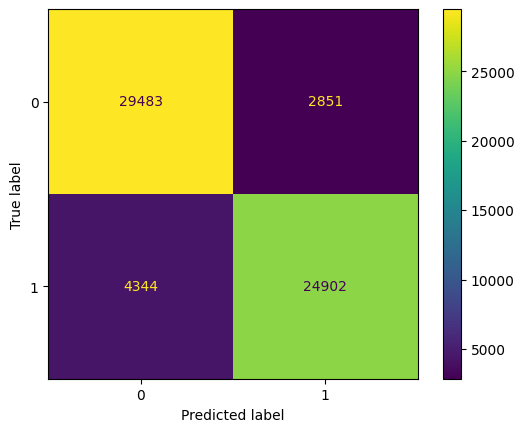

In [243]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

#### Here we may see the disbalance in class No. 1. That's why we should use the outdoor class augmentation where the model fails. 
#### I'll do it later.

#### Let's correct the model and add some convolution layers:

In [310]:
class CNNIndoorOutdoorDoubleConv(nn.Module):
    
    def __init__(self):
        super(CNNIndoorOutdoorDoubleConv, self).__init__()
        self.convolution_layers = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_image):
        x = self.convolution_layers(input_image)
        x = x.view(x.size(0), -1)  
        x = self.fully_connected_layers(x)
        
        return x

In [114]:
writer = SummaryWriter('runs/running_indoor_outdoor_model_double_convolution')

In [311]:
modelCNNIndoorOutdoorDoubleConv = CNNIndoorOutdoorDoubleConv()  
optimizer = optim.Adam(modelCNNIndoorOutdoorDoubleConv.parameters(), lr=0.001) 
criterion = nn.BCELoss()

In [142]:
train_model(modelCNNIndoorOutdoorDoubleConv, train_loader, val_loader, criterion, optimizer, file = 'double_conv_model.pth', num_epochs=30, first_flag=False)

Checkpoint loaded. Epoch: 5, Loss: 0.28389355540275574, Accuracy: 0.8840494981974082


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_82004/1842714039.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8683
Average Loss on test set: 0.3256
Epoch [1/30], Loss: 0.2919, Accuracy: 0.8842, Val Loss: 0.3256, Val Accuracy: 0.8683


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8914
Average Loss on test set: 0.2786
Epoch [2/30], Loss: 0.2957, Accuracy: 0.8852, Val Loss: 0.2786, Val Accuracy: 0.8914
Validation accuracy improved from 0.8840 to 0.8914. Saving model...


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8821
Average Loss on test set: 0.2878
Epoch [3/30], Loss: 0.2809, Accuracy: 0.8886, Val Loss: 0.2878, Val Accuracy: 0.8821


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8845
Average Loss on test set: 0.2835
Epoch [4/30], Loss: 0.2821, Accuracy: 0.8900, Val Loss: 0.2835, Val Accuracy: 0.8845


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8849
Average Loss on test set: 0.2824
Epoch [5/30], Loss: 0.2783, Accuracy: 0.8908, Val Loss: 0.2824, Val Accuracy: 0.8849


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8889
Average Loss on test set: 0.2780
Epoch [6/30], Loss: 0.2748, Accuracy: 0.8927, Val Loss: 0.2780, Val Accuracy: 0.8889


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8938
Average Loss on test set: 0.2618
Epoch [7/30], Loss: 0.2828, Accuracy: 0.8926, Val Loss: 0.2618, Val Accuracy: 0.8938
Validation accuracy improved from 0.8914 to 0.8938. Saving model...


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8944
Average Loss on test set: 0.2689
Epoch [8/30], Loss: 0.2692, Accuracy: 0.8946, Val Loss: 0.2689, Val Accuracy: 0.8944
Validation accuracy improved from 0.8938 to 0.8944. Saving model...


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8924
Average Loss on test set: 0.2694
Epoch [9/30], Loss: 0.2777, Accuracy: 0.8929, Val Loss: 0.2694, Val Accuracy: 0.8924


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8914
Average Loss on test set: 0.2855
Epoch [10/30], Loss: 0.2722, Accuracy: 0.8944, Val Loss: 0.2855, Val Accuracy: 0.8914


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8918
Average Loss on test set: 0.2693
Epoch [11/30], Loss: 0.2685, Accuracy: 0.8958, Val Loss: 0.2693, Val Accuracy: 0.8918


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8910
Average Loss on test set: 0.2717
Epoch [12/30], Loss: 0.2655, Accuracy: 0.8969, Val Loss: 0.2717, Val Accuracy: 0.8910


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8958
Average Loss on test set: 0.2620
Epoch [13/30], Loss: 0.2630, Accuracy: 0.8971, Val Loss: 0.2620, Val Accuracy: 0.8958
Validation accuracy improved from 0.8944 to 0.8958. Saving model...


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8918
Average Loss on test set: 0.2696
Epoch [14/30], Loss: 0.2594, Accuracy: 0.8998, Val Loss: 0.2696, Val Accuracy: 0.8918


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8815
Average Loss on test set: 0.3102
Epoch [15/30], Loss: 0.2715, Accuracy: 0.8981, Val Loss: 0.3102, Val Accuracy: 0.8815


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8911
Average Loss on test set: 0.2760
Epoch [16/30], Loss: 0.2643, Accuracy: 0.8972, Val Loss: 0.2760, Val Accuracy: 0.8911


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8941
Average Loss on test set: 0.2739
Epoch [17/30], Loss: 0.2669, Accuracy: 0.8979, Val Loss: 0.2739, Val Accuracy: 0.8941


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8984
Average Loss on test set: 0.2597
Epoch [18/30], Loss: 0.2577, Accuracy: 0.8990, Val Loss: 0.2597, Val Accuracy: 0.8984
Validation accuracy improved from 0.8958 to 0.8984. Saving model...


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8945
Average Loss on test set: 0.2636
Epoch [19/30], Loss: 0.2591, Accuracy: 0.9001, Val Loss: 0.2636, Val Accuracy: 0.8945


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8936
Average Loss on test set: 0.2674
Epoch [20/30], Loss: 0.2542, Accuracy: 0.9001, Val Loss: 0.2674, Val Accuracy: 0.8936


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8980
Average Loss on test set: 0.2554
Epoch [21/30], Loss: 0.2560, Accuracy: 0.9027, Val Loss: 0.2554, Val Accuracy: 0.8980


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8992
Average Loss on test set: 0.2595
Epoch [22/30], Loss: 0.2597, Accuracy: 0.8986, Val Loss: 0.2595, Val Accuracy: 0.8992
Validation accuracy improved from 0.8984 to 0.8992. Saving model...


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8955
Average Loss on test set: 0.2638
Epoch [23/30], Loss: 0.2572, Accuracy: 0.9022, Val Loss: 0.2638, Val Accuracy: 0.8955


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8915
Average Loss on test set: 0.2821
Epoch [24/30], Loss: 0.2682, Accuracy: 0.8997, Val Loss: 0.2821, Val Accuracy: 0.8915


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8978
Average Loss on test set: 0.2747
Epoch [25/30], Loss: 0.2680, Accuracy: 0.8997, Val Loss: 0.2747, Val Accuracy: 0.8978


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8960
Average Loss on test set: 0.2604
Epoch [26/30], Loss: 0.2755, Accuracy: 0.8960, Val Loss: 0.2604, Val Accuracy: 0.8960


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8941
Average Loss on test set: 0.2711
Epoch [27/30], Loss: 0.2669, Accuracy: 0.9009, Val Loss: 0.2711, Val Accuracy: 0.8941


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8959
Average Loss on test set: 0.2685
Epoch [28/30], Loss: 0.2606, Accuracy: 0.9006, Val Loss: 0.2685, Val Accuracy: 0.8959


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8944
Average Loss on test set: 0.2688
Epoch [29/30], Loss: 0.2609, Accuracy: 0.8999, Val Loss: 0.2688, Val Accuracy: 0.8944


  0%|          | 0/3208 [00:00<?, ?it/s]

Accuracy on test set: 0.8746
Average Loss on test set: 0.3060
Epoch [30/30], Loss: 0.2641, Accuracy: 0.8984, Val Loss: 0.3060, Val Accuracy: 0.8746


#### Lower lr:

In [143]:
optimizer = optim.Adam(modelCNNIndoorOutdoorDoubleConv.parameters(), lr=0.0001) 

In [312]:
load_checkpoint(modelCNNIndoorOutdoorDoubleConv, optimizer, filename='double_conv_model.pth')

Checkpoint loaded. Epoch: 22, Loss: 0.2594602406024933, Accuracy: 0.8992010133489233


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_82004/3350788925.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


(22, tensor(0.2595), 0.8992010133489233)

In [ ]:
train_model(modelCNNIndoorOutdoorDoubleConv, train_loader, val_loader, criterion, optimizer, file = 'double_conv_model.pth', num_epochs=5, first_flag=False)

#### Evaluate:

In [ ]:
cp, cm, acc = predict_model(modelCNNIndoorOutdoorDoubleConv, test_loader, 'cpu', 642)

In [307]:
print(acc)

0.8999594155844156


In [163]:
print(cp)

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     33449
         1.0       0.90      0.89      0.89     30615

    accuracy                           0.90     64064
   macro avg       0.90      0.90      0.90     64064
weighted avg       0.90      0.90      0.90     64064



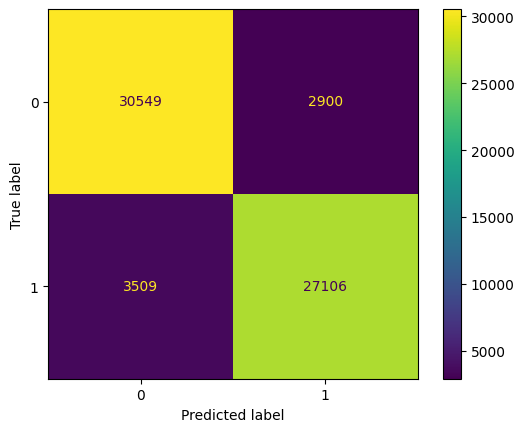

In [164]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Visualize errors:

  0%|          | 0/8981 [00:00<?, ?it/s]

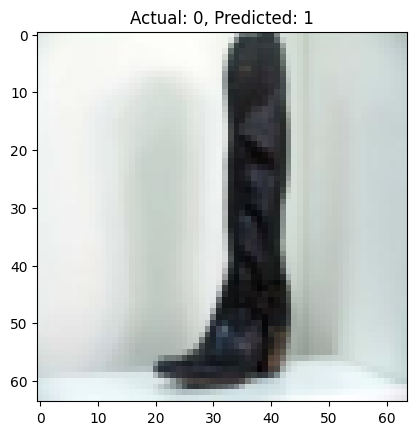

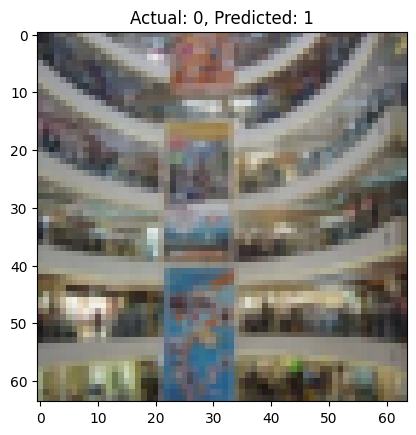

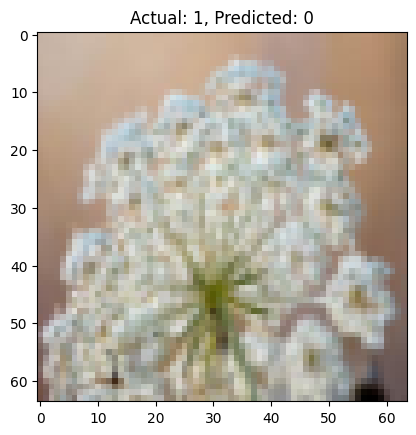

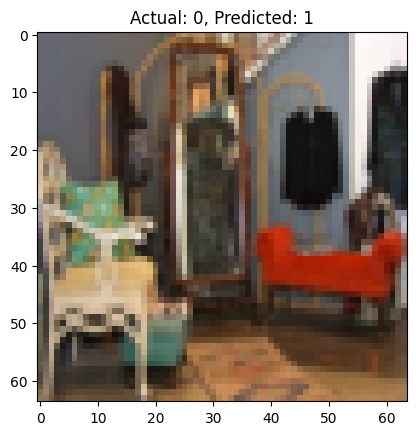

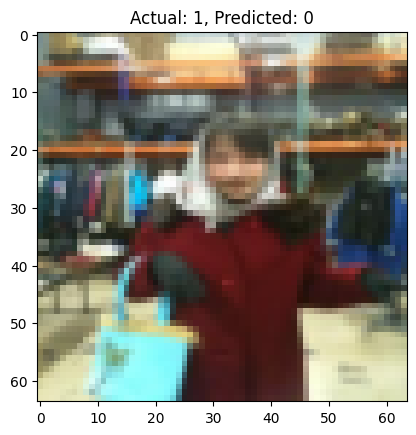

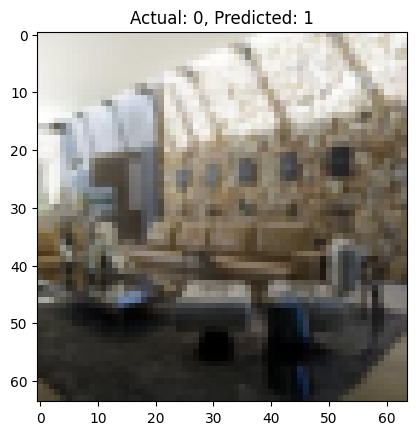

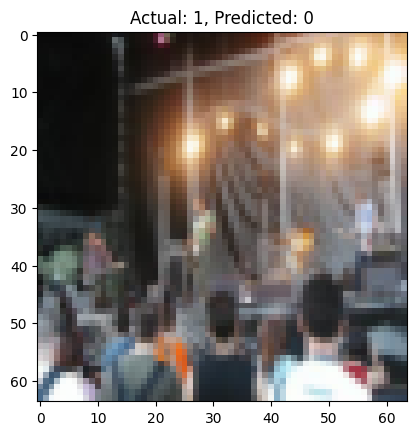

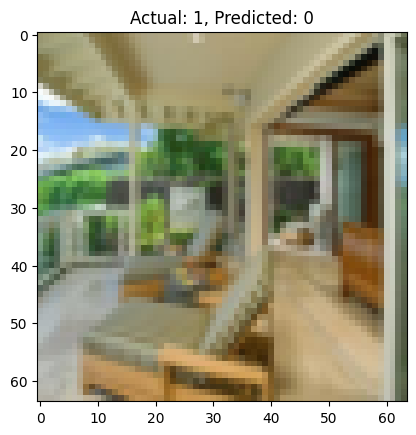

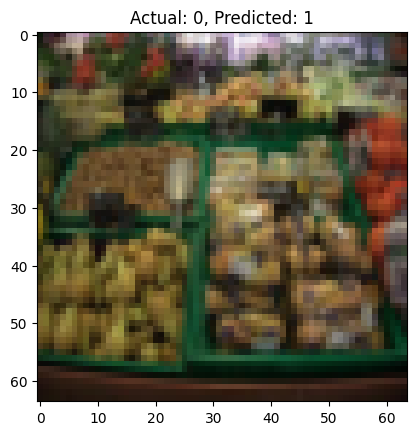

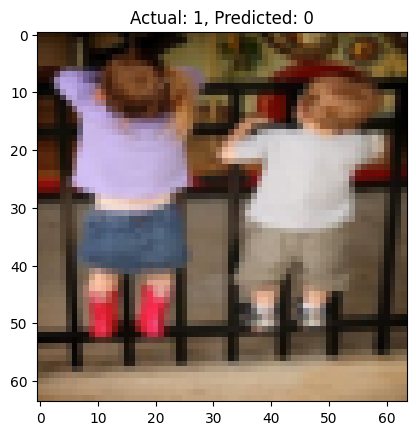

In [167]:
def imshow(img, title):
    """image show function"""
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def inference_and_visualize_errors(model, test_loader, device ='cpu', threshold = 642):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float().view(-1)

            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(predicted[idx].cpu().item())
            if i > threshold:
                break

    for i in range(min(10, len(incorrect_images))):
        imshow(incorrect_images[i], f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

        writer.add_image(f'Error_{i}', incorrect_images[i])
        writer.add_text(f'Error_{i}', f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

inference_and_visualize_errors(modelCNNIndoorOutdoorDoubleConv, test_loader)


#### Let's try pre-trained VGG16:

In [291]:
pretrained_vgg16 = vgg16(pretrained = True)

In [292]:
pretrained_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [293]:
for param in pretrained_vgg16.features.parameters():
    param.requires_grad = False

In [294]:
num_ftrs = pretrained_vgg16.classifier[6].in_features
pretrained_vgg16.classifier[6] = nn.Linear(num_ftrs, 1) 

In [295]:
for params in pretrained_vgg16.classifier.parameters():
    params.requires_grad = True

In [300]:
for name, params in pretrained_vgg16.named_parameters():
    
    if params.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [305]:
transform_images_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader, val_loader, test_loader = load_datasets(batch_size=32, transform=transform_images_224, train_size=0.03, val_size=0.05)

In [298]:
writer = SummaryWriter('runs/running_indoor_outdoor_model_vgg')

In [299]:
pretrained_vgg16.classifier.add_module('sigmoid', nn.Sigmoid())

In [286]:
optimizer = optim.Adam(pretrained_vgg16.parameters(), lr=0.001) 
criterion = nn.BCELoss()

In [ ]:
train_model(pretrained_vgg16, train_loader, val_loader, criterion, optimizer, file = 'vgg16_model.pth', num_epochs=5, first_flag=True)